In [1]:
# !rm -rf output/*

In [2]:
# affine = 'flirt'
affine = 'synthmorph'

# deformable = 'synthmorph_cmd'
deformable = 'synthmorph_vxm'

In [3]:
# Clone Guray's repo
# !rm -rf SingleScanAnalysis

# !git clone https://github.com/gurayerus/SingleScanAnalysis.git
# !cp SingleScanAnalysis/test/input/* .
# !cp SingleScanAnalysis/src/pipeline_dl/utils_mri.py .

# Skull stripped images
# !cp SingleScanAnalysis/src/pipeline_istag/RAVENS_Pipeline_Simple/input/Subj1/Subj1_T1_LPS_dlicv.nii.gz .
# !cp SingleScanAnalysis/src/pipeline_istag/RAVENS_Pipeline_Simple/templates/colin27_t1_tal_lin.nii.gz .

In [4]:
# # Packages from GitHub.
# !pip -q install git+https://github.com/adalca/neurite.git@0776a575eadc3d10d6851a4679b7a305f3a31c65
# !pip -q install git+https://github.com/freesurfer/surfa.git@ec5ddb193fd1caf22ec654c457b5678f6bd8e460
# !pip -q install git+https://github.com/voxelmorph/voxelmorph.git@2cd706189cb5919c6335f34feec672f05203e36b

In [5]:
# !pip install tensorflow==2.18
# !pip install keras==3.08

!pip show tensorflow
!pip show keras
# !conda env list

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/anaconda3/envs/mri/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 
Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /opt/anaconda3/envs/mri/lib/python3.12/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [6]:
# !pip -q install nilearn

In [7]:
import numpy as np
import os
import surfa as sf
import tensorflow as tf
import voxelmorph as vxm
import matplotlib.pyplot as plt

In [8]:
# Downloads.
# !curl -O https://surfer.nmr.mgh.harvard.edu/ftp/data/voxelmorph/synthmorph/shapes-dice-vel-3-res-8-16-32-256f.h5

In [9]:
# Helper functions. The shape has to be divisible by 16.
# shape = (128, 128, 128)
shape = (256, 256, 256)

def normalize(x):
    x = np.float32(x)
    x -= x.min()
    x /= x.max()
    return x[None, ..., None]

def show(x, title=None):
  x = np.squeeze(x)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  i, j, k = (f // 2 for f in x.shape)

  slices = x[:, j, :], x[:, :, k], x[i, :, :].T
  for x, ax in zip(slices, axes):
    ax.imshow(x, cmap='gray')
    ax.set_axis_off()

  if title:
    axes[1].text(0.50, 1.05, title, ha='center', transform=axes[1].transAxes, size=14)

In [10]:
# # Load, transform, and display the first high VN scan

# ###### Do we need reshape? (or even resize?)

# # high_vn_1 = sf.load_volume('/Volumes/home/mri_samples/T1/137_S_4227_2011-09-21_T1_LPS.nii.gz').resize(voxsize=2).reshape(target_shape).reorient('ILP')
# high_vn_1 = sf.load_volume('../mri_samples/T1/137_S_4227_2011-09-21_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(high_vn_1, title='Extremely High VN: 137_S_4227')

# # Load, transform, and display the second high VN scan
# high_vn_2 = sf.load_volume('../mri_samples/T1/013_S_4236_2011-10-13_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(high_vn_2, title='Extremely High VN: 013_S_4236')

In [11]:
# # Load, transform, and display the first small VN scan
# small_vn_1 = sf.load_volume('../mri_samples/T1/019_S_6635_2020-01-28_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(small_vn_1, title='Extremely Small VN: 019_S_6635')

# # Load, transform, and display the second small VN scan
# small_vn_2 = sf.load_volume('../mri_samples/T1/072_S_4226_2012-10-12_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(small_vn_2, title='Extremely Small VN: 072_S_4226')

In [12]:
# # Load, transform, and display the first mean VN scan
# mean_vn_1 = sf.load_volume('../mri_samples/T1/023_S_1247_2007-02-21_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(mean_vn_1, title='Mean VN: 023_S_1247')

# # Load, transform, and display the second mean VN scan
# mean_vn_2 = sf.load_volume('../mri_samples/T1/027_S_0118_2008-02-23_T1_LPS.nii.gz').resize(voxsize=2).reorient('ILP')
# show(mean_vn_2, title='Mean VN: 027_S_0118')

In [13]:
# subj1_path = "../mri_samples/T1/023_S_1247_2007-02-21_T1_LPS.nii.gz" # Yuhan's mean VN scan
# template_path = "../mri_samples/template/BLSA_SPGR+MPRAGE_averagetemplate.nii.gz" # Yuhan's template
# template_path = "../mri_samples/T1/137_S_4227_2011-09-21_T1_LPS.nii.gz" # Yuhan's high VN scan

In [14]:
subj1_path = "out_synth/subj1/init/subj1_t1.nii.gz" # Guray's Inverted Input 1
subj2_path = "out_synth/subj2/init/subj2_t1.nii.gz" # Guray's Inverted Input 2
template_path = "out_synth/template/colin27_t1_tal_lin_INV.nii.gz" # Guray's Inverted Template

subjects_list = ["subj1", "subj2"]

# Segmentation

In [15]:
# Just use Guray's segmented image
out_seg = "out_synth/subj1/init/subj1_t1_seg.nii.gz"

In [16]:
# import utils_mri as utilmri
# import os

# # STEP 1:
# # Segmentation with SynthSeg
# NUMTHD = 4
# out_dir = 'output'

# sub_id = "Img1"
# sub_img = template_path

# ref_id = "Img2"
# ref_img = subj1_path

# for tmp_id, tmp_img in [[sub_id, sub_img], [ref_id, ref_img]]:

#     # Reorient images
#     print('Reorienting image ...')
#     out_sub = os.path.join(out_dir, 'reoriented', tmp_id)
#     if not os.path.exists(out_sub):
#         os.makedirs(out_sub)
#     out_reorient = os.path.join(out_sub, tmp_id + '_T1_LPS.nii.gz')
#     if not os.path.exists(out_reorient):
#         utilmri.reorient_img(tmp_img, 'LPS', out_reorient)
#     else:
#         print(f'Out file exists, skip: {out_reorient}')

#     # Segment image
#     print('Segmenting image ...')
#     out_sub = os.path.join(out_dir, 'segmented', tmp_id)
#     if not os.path.exists(out_sub):
#         os.makedirs(out_sub)
#     out_seg = os.path.join(out_sub, tmp_id + '_Seg.nii.gz')
#     out_qc = os.path.join(out_sub, tmp_id + '_Seg_QC.csv')
#     out_vol = os.path.join(out_sub, tmp_id + '_Seg_Vol.csv')
#     out_post = os.path.join(out_sub, tmp_id + '_Seg_Post.nii.gz')
#     out_resample = os.path.join(out_sub, tmp_id + '_Seg_Resample.nii.gz')
#     cmd = f'mri_synthseg --i {out_reorient} --o {out_seg} --robust --vol {out_vol} --qc {out_qc} --resample {out_resample} --threads {NUMTHD} --cpu'
#     if not os.path.exists(out_seg):
#         print(f'About to run: {cmd}')
#         os.system(cmd)
#     else:
#         print(f'Out file exists, skip: {out_seg}')


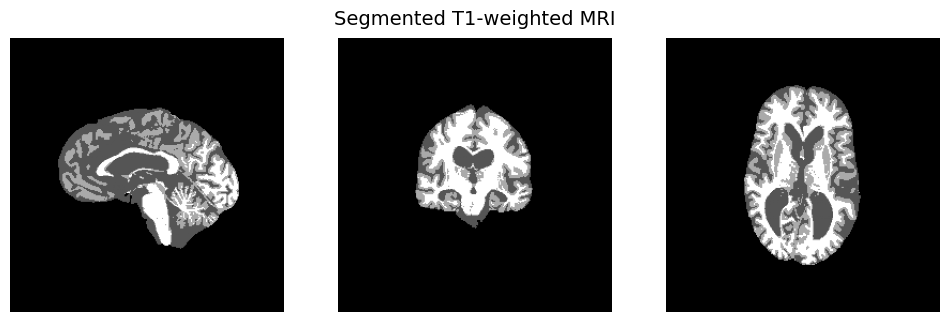

In [17]:
# t1_seg = sf.load_volume(out_seg).resize(voxsize=2).reshape(shape).reorient('ILP')
t1_seg = sf.load_volume(out_seg).reshape(shape).reorient('ILP')


show(t1_seg, title='Segmented T1-weighted MRI')

# Create Binary Mask of the Segmented Image

In [18]:
# Cerebrospinal Fluid (CSF)
csf_labels = [4, 5, 14, 15, 24, 43, 44]

# Gray Matter (includes cortex and deep gray matter structures)
gray_matter_labels = [3, 8, 10, 11, 12, 13, 16, 17, 18, 26, 28, 42, 47, 49, 50, 51, 52, 53, 54, 58, 60]

# White Matter
white_matter_labels = [2, 7, 41, 46]

# Background
background_label = [0]



# # 🧠 Gray Matter
# # Includes cerebral and cerebellar cortices.
# gray_matter_labels = [3, 8, 42, 47]

# # 🧱 Deep Gray Matter
# # Subcortical structures like the thalamus, basal ganglia, hippocampus, and amygdala.
# deep_gray_matter_labels = [10, 11, 12, 13, 17, 18, 26, 28, 49, 50, 51, 52, 53, 54, 58, 60]

# # ⚪ White Matter
# # Cerebral and cerebellar white matter tracts.
# white_matter_labels = [2, 7, 41, 46]

# # 💧 Ventricles & CSF
# # Fluid-filled spaces and cerebrospinal fluid.
# ventricles_labels = [4, 5, 14, 15, 43, 44]

# ventricles_csf_labels = [4, 5, 14, 15, 24, 43, 44]

# csf_label = [24]


# #  miscellaneous
# # Other essential structures.
# misc_labels = [0, 16]

# # You can also combine them into a dictionary for easy access by name.
# grouped_labels = {
#     "gray_matter": gray_matter_labels,
#     "deep_gray_matter": deep_gray_matter_labels,
#     "white_matter": white_matter_labels,
#     "ventricles": ventricles_labels,
#     "ventricles_and_csf": ventricles_csf_labels,
#     "misc": misc_labels
# }


In [19]:
import nibabel as nib

target_labels = [1]
# target_labels = white_matter_labels
print(target_labels)

# Assume 'seg_moving' is the loaded segmentation volume from the previous cell
# Get the data array from the segmentation
    # nii_seg = nib.load(f_seg)

seg_data = t1_seg.data

# Create a binary mask.
# This sets all voxels with the target labels to True, and all others to False.
# We then convert the boolean values (True/False) to integers (1/0).
mask_data = np.isin(seg_data, target_labels).astype(np.uint8)


# Create a new NIfTI image for the mask.
# It's important to use the affine matrix from the original segmentation
# to ensure the mask has the same orientation, position, and voxel size.

# csf_mask_nii = nib.Nifti1Image(csf_mask_data, t1_seg.affine)

# Corrected line
affine_matrix = np.asarray(t1_seg.geom.vox2world)
csf_mask_nii = nib.Nifti1Image(mask_data, affine_matrix)

# Save the binary mask to a NIfTI file
output_filename = 'out_synth/subj1/init/subj1_t1_mask.nii.gz'
nib.save(csf_mask_nii, output_filename)

print(f"Binary mask saved to: {output_filename}")

[1]
Binary mask saved to: out_synth/subj1/init/subj1_t1_mask.nii.gz


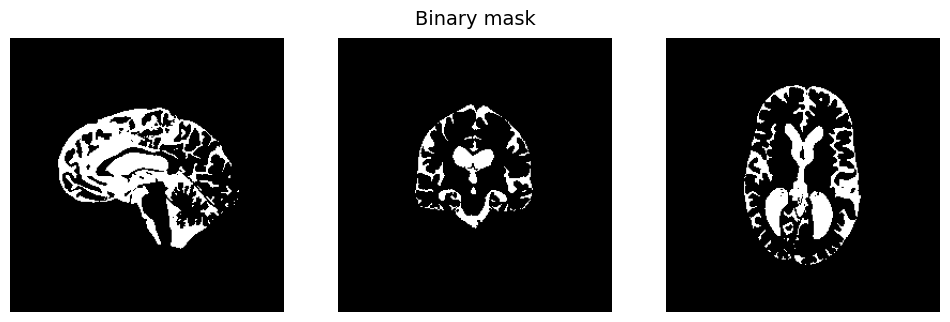

In [20]:
temp1 = sf.load_volume("out_synth/subj1/init/subj1_t1_mask.nii.gz").reshape(shape).reorient('ILP')
show(temp1, title='Binary mask')


# temp2 = sf.load_volume("output/csf_binary_mask2.nii.gz").reshape(shape).reorient('ILP')
# temp2 = sf.load_volume("output/csf_binary_mask2.nii.gz").resample_like(temp1)
# show(temp2, title='New binary mask')

# Affine Registration

In [21]:
affine_moved = "out_synth/subj1/lin_reg/subj1_t1_reg.nii.gz"
affine_moving = subj1_path
affine_fixed = template_path

In [22]:
if affine == 'synthmorph':

    matrix_filepath = "out_synth/subj1/lin_reg/subj1_t1_trans.lta"
    
    # Estimate and save an affine transform trans.lta in FreeSurfer LTA format
    cmd1 = f'mri_synthmorph register -m affine -t {matrix_filepath} {affine_moving} {affine_fixed}'

    # Apply an existing transform to an image
    cmd2 = f'mri_synthmorph apply {matrix_filepath} {affine_moving} {affine_moved}'

    if not os.path.exists(affine_moved):
        print(f'About to run: {cmd1}')
        os.system(cmd1)

        print(f'About to run: {cmd2}')
        os.system(cmd2)
    else:
        print(f'Out file exists, skip: {affine_moved}')

elif affine == 'flirt':

    matrix_filepath = "out_synth/subj1/lin_reg/subj1_t1_trans.mat"
    
    # cmd1 = f'flirt -in {affine_moving} -ref {affine_fixed} -out {affine_moved} -omat {matrix_filepath} -dof 12'

    # Skull strip images
    cmd1 = f'bet {affine_moving} output/stripped.nii.gz'

    # Register
    cmd2 = f'flirt -in output/stripped.nii.gz -ref {affine_fixed} -out {affine_moved} -omat {matrix_filepath} -dof 12'


    if not os.path.exists(affine_moved):
        print(f'About to run: {cmd1}')
        os.system(cmd1)

        # print(f'About to run: {cmd2}')
        os.system(cmd2)
    else:
        print(f'Out file exists, skip: {affine_moved}')


Out file exists, skip: out_synth/subj1/lin_reg/subj1_t1_reg.nii.gz


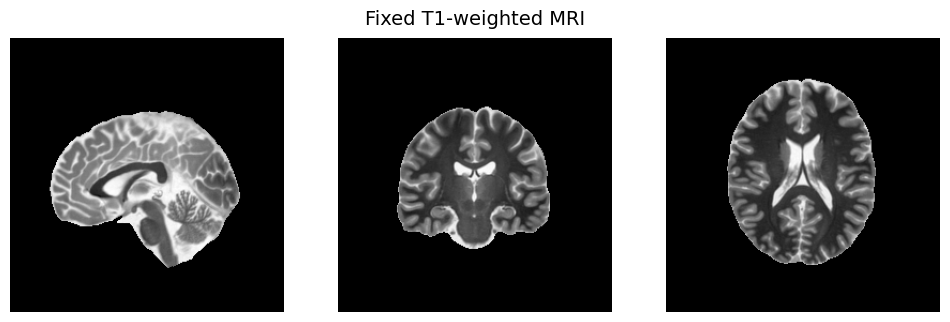

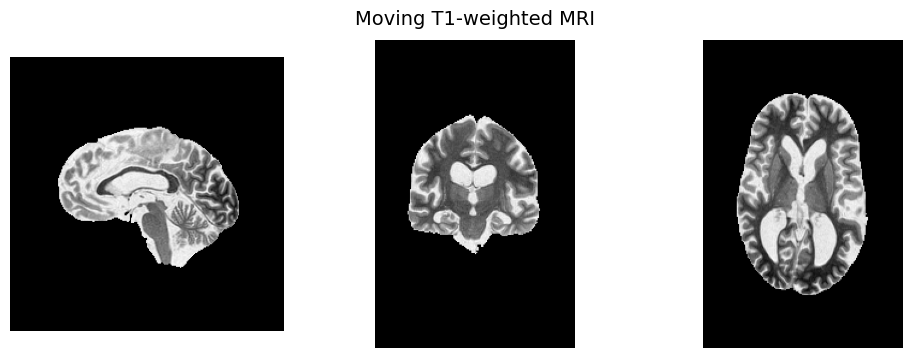

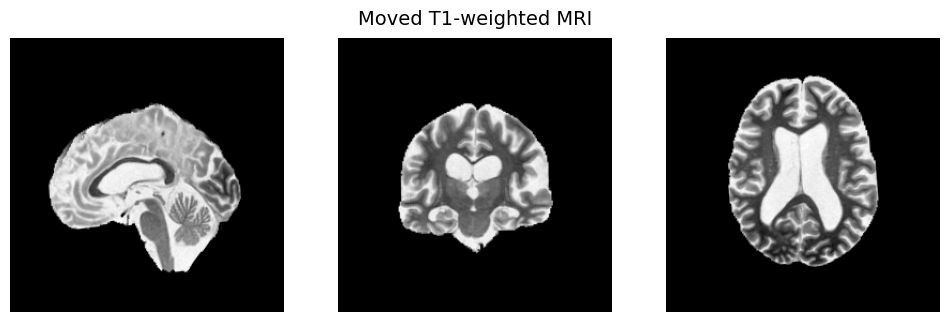

In [23]:
# Load both volumes
t1_fixed = sf.load_volume(affine_fixed).reshape(shape).reorient('ILP')

# t1_moving2 = sf.load_volume("output/stripped.nii.gz")


# t1_moving = sf.load_volume(affine_moving).resample_like(t1_fixed)
t1_moving = sf.load_volume(affine_moving).reorient('ILP')

t1_moved = sf.load_volume(affine_moved).resample_like(t1_fixed)

show(t1_fixed, title='Fixed T1-weighted MRI')
# show(t1_moving2, title='Stripped')

show(t1_moving, title='Moving T1-weighted MRI')
show(t1_moved, title='Moved T1-weighted MRI')

## Apply the affine step to the segmentation

In [24]:
# Apply the affine step to the segmentation

seg_affine_moved = "out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz"
# seg_affine_moving = "output/segmented/Img2/Img2_Seg.nii.gz"
seg_affine_moving = "out_synth/subj1/init/subj1_t1_mask.nii.gz"


if affine == 'synthmorph':

    # Apply an existing transform to an image
    cmd = f'mri_synthmorph apply -m nearest {matrix_filepath} {seg_affine_moving} {seg_affine_moved}'

    if not os.path.exists(seg_affine_moved):
        print(f'About to run: {cmd}')
        os.system(cmd)
    else:
        print(f'Out file exists, skip: {seg_affine_moved}')

elif affine == 'flirt':

    cmd = f'flirt -in {seg_affine_moving} -ref {affine_fixed} -out {seg_affine_moved} -init {matrix_filepath} -applyxfm'

    if not os.path.exists(seg_affine_moved):
        print(f'About to run: {cmd}')
        os.system(cmd)
    else:
        print(f'Out file exists, skip: {seg_affine_moved}')


Out file exists, skip: out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz


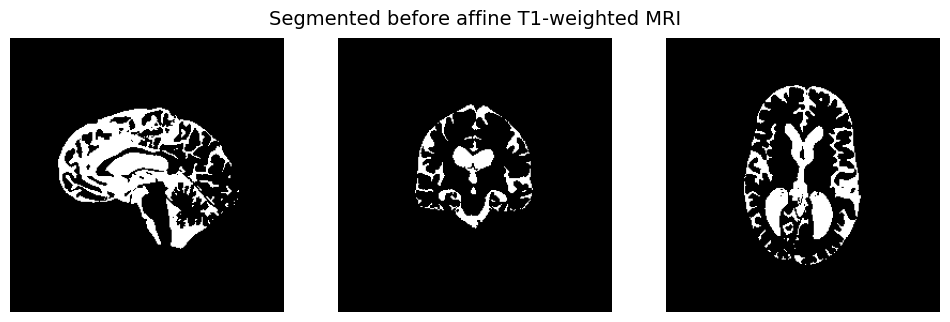

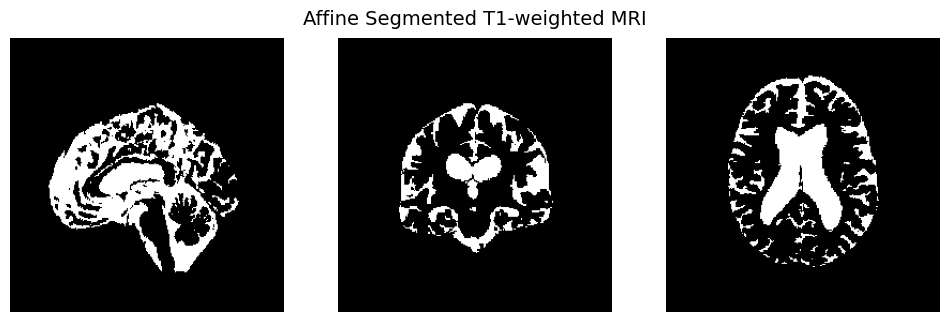

In [25]:
t1_seg_before = sf.load_volume(seg_affine_moving).resample_like(t1_seg)
show(t1_seg_before, title='Segmented before affine T1-weighted MRI')

t1_seg = sf.load_volume(seg_affine_moved).reshape(shape).reorient('ILP')
show(t1_seg, title='Affine Segmented T1-weighted MRI')

# Calculate Scale Factor for the Affine Registration

## Calculate Actual scale factor from various ROIs

In [26]:
import numpy as np
import io
import os

def calculate_volume_change_from_matrix(matrix: np.ndarray) -> float:
    """
    Calculates the volume change factor from a 4x4 affine matrix.

    The factor is the absolute value of the determinant of the top-left
    3x3 submatrix (the linear transformation part).
    
    Args:
        matrix: A 4x4 NumPy array representing the affine transformation.
        
    Returns:
        The volume change factor k, where new_volume = k * old_volume.
    """
    if matrix.shape != (4, 4):
        raise ValueError("Input must be a 4x4 transformation matrix.")
    
    # Extract the top-left 3x3 linear transformation submatrix
    linear_part = matrix[0:3, 0:3]
    
    # The volume change factor is the determinant of this submatrix
    determinant = np.linalg.det(linear_part)
    
    return abs(determinant)

def parse_flirt_mat_file(filepath: str) -> np.ndarray:
    """
    Parses a simple space-delimited text file, like a FSL FLIRT .mat file.
    """
    print(f"📄 Reading FLIRT file: {filepath}")
    try:
        # np.loadtxt is perfect for simple text-based matrices
        matrix = np.loadtxt(filepath)
        return matrix
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return None

def parse_freesurfer_lta_file(filepath: str) -> np.ndarray:
    """
    Parses a FreeSurfer LTA file to extract the 4x4 transformation matrix.
    """
    print(f"📄 Reading LTA file: {filepath}")
    matrix_lines = []
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        # The line '1 4 4' signals that the next 4 lines are the matrix
        start_index = lines.index('1 4 4\n') + 1
        matrix_lines = lines[start_index : start_index + 4]

        # Use numpy to parse the extracted lines
        matrix = np.loadtxt(io.StringIO("".join(matrix_lines)))
        return matrix
        
    except (ValueError, IndexError) as e:
        # Handles cases where '1 4 4' is not found or file is malformed
        print(f"Error parsing {filepath}: Could not find the matrix start signal. {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred with {filepath}: {e}")
        return None

In [27]:
import numpy as np
import nibabel as nib
import os

def calculate_physical_volume_change(
    flirt_matrix: np.ndarray,
    moving_image_path: str,
    ref_image_path: str
) -> float:
    """
    Calculates the true physical volume change factor from a FLIRT matrix
    by incorporating the voxel dimensions of the moving and reference images.
    
    Args:
        flirt_matrix: 4x4 NumPy array from the FLIRT .mat file.
        moving_image_path: Filepath to the original moving image (.nii or .nii.gz).
        ref_image_path: Filepath to the reference image (.nii or .nii.gz).
        
    Returns:
        The physical volume change factor k.
    """
    # 1. Calculate the determinant of the linear part of the matrix
    if flirt_matrix.shape != (4, 4):
        raise ValueError("Input must be a 4x4 transformation matrix.")
    
    linear_part = flirt_matrix[0:3, 0:3]
    matrix_determinant = np.linalg.det(linear_part)
    
    # 2. Get voxel dimensions from the NIfTI headers
    try:
        moving_img = nib.load(moving_image_path)
        ref_img = nib.load(ref_image_path)
        
        # get_zooms() returns voxel dims (dx, dy, dz, ...)
        moving_vox_dims = moving_img.header.get_zooms()[:3]
        ref_vox_dims = ref_img.header.get_zooms()[:3]
        
    except FileNotFoundError as e:
        print(f"🚨 Error: Could not find image file - {e}")
        return None
    except Exception as e:
        print(f"🚨 Error loading NIfTI files: {e}")
        return None

    # 3. Calculate the physical volume of a single voxel for each image
    moving_voxel_volume = np.prod(moving_vox_dims)
    ref_voxel_volume = np.prod(ref_vox_dims)
    
    # 4. Calculate the voxel volume ratio
    if moving_voxel_volume == 0:
        raise ValueError("Moving image voxel volume cannot be zero.")
    voxel_volume_ratio = ref_voxel_volume / moving_voxel_volume
    
    # 5. Compute the final physical volume change factor
    k_physical = abs(matrix_determinant) * voxel_volume_ratio
    
    print("--- Calculation Details ---")
    print(f"Matrix Determinant    : {matrix_determinant:.4f}")
    print(f"Moving Voxel Volume   : {moving_voxel_volume:.4f} mm³")
    print(f"Reference Voxel Volume: {ref_voxel_volume:.4f} mm³")
    print(f"Voxel Volume Ratio    : {voxel_volume_ratio:.4f}")
    print("-------------------------")
    
    return k_physical


In [28]:
if affine == "synthmorph":
    # Process the SynthMorph/LTA file
    lta_matrix = parse_freesurfer_lta_file(matrix_filepath)
    print(lta_matrix)
    if lta_matrix is not None:
        scale_factor = calculate_volume_change_from_matrix(lta_matrix)
        print(f"📈 SynthMorph Volume Change Factor (k): {scale_factor:.4f}\n")

elif affine == 'flirt':
    # Process the FLIRT file
    flirt_matrix = parse_flirt_mat_file(matrix_filepath)
    print(flirt_matrix)
    if flirt_matrix is not None:
        # scale_factor = calculate_volume_change_from_matrix(flirt_matrix)
        # print(f"📈 FLIRT Volume Change Factor (k): {scale_factor:.4f}\n")

        scale_factor = calculate_physical_volume_change(flirt_matrix, subj1_path, template_path)
        print(f"📈 FLIRT Volume Change Factor (k): {scale_factor:.4f}\n")



📄 Reading LTA file: out_synth/subj1/lin_reg/subj1_t1_trans.lta
[[ 1.08407874e+00  8.36782614e-02  1.64656259e-02 -2.74568849e+02]
 [-1.09486054e-01  1.04447237e+00  6.67676290e-02 -3.27656132e+02]
 [-1.33002895e-02 -1.27954732e-01  1.19038074e+00 -5.97105828e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
📈 SynthMorph Volume Change Factor (k): 1.3684



## Validate Scale Factor Value from the actual data

In [29]:
import nibabel as nib
import numpy as np
from pathlib import Path

def calculate_nifti_volume(filepath: str | Path, verbose: bool = False) -> float:
    """
    Calculates the total volume of non-zero voxels in a NIfTI file.

    This function loads a NIfTI file, counts the number of voxels with a
    value other than zero, determines the volume of a single voxel from the
    file's header, and computes the total volume.

    Args:
        filepath (str | Path): The full path to the input NIfTI file 
                               (e.g., 'data/subject_01.nii.gz').
        verbose (bool): If True, prints the voxel count, volume per voxel,
                        and total volume to the console. Defaults to False.

    Returns:
        float: The total volume of the non-zero voxels, typically in mm³.
    
    Raises:
        FileNotFoundError: If the file specified by filepath does not exist.
        Exception: Catches and re-raises other potential errors from nibabel.
    """
    try:
        # Ensure the filepath is a Path object for robust handling
        nii_path = Path(filepath)
        if not nii_path.exists():
            raise FileNotFoundError(f"Error: The file was not found at {filepath}")

        # Load the NIfTI file
        nii_file = nib.load(nii_path)

        # Get the image data as a NumPy array
        data = nii_file.get_fdata()

        # 1. Count the number of non-zero voxels
        voxel_count = np.count_nonzero(data)

        # 2. Get the volume of a single voxel from the header's zoom info
        # The first three zoom values correspond to the dimensions (x, y, z)
        voxel_volume = np.prod(nii_file.header.get_zooms()[:3])

        # 3. Calculate the total volume
        total_volume = voxel_count * voxel_volume

        if verbose:
            print(f"--- Volume Calculation Details ---")
            print(f"File: {nii_path.name}")
            print(f"Number of non-zero voxels: {voxel_count}")
            print(f"Volume per voxel: {voxel_volume:.4f} mm³")
            print(f"Total volume of structure: {total_volume:.4f} mm³")
            print(f"------------------------------------")

        return total_volume

    except FileNotFoundError as e:
        print(e)
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise



In [30]:
# Calculate Volume 1
volume_1 = calculate_nifti_volume('out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz')
print(f"\nCalculated Volume 1: {volume_1:.4f} mm³")
# Calculate Volume 2
volume_2 = calculate_nifti_volume('out_synth/subj1/init/subj1_t1_mask.nii.gz')
print(f"\nCalculated Volume 2: {volume_2:.4f} mm³")

# Calculate the scale factor by dividing the volumes
actual_scale_factor = volume_1 / volume_2
print(f"\nCalculated Scale Factor: {actual_scale_factor:.4f} mm³")


Calculated Volume 1: 615206.0000 mm³

Calculated Volume 2: 449196.9811 mm³

Calculated Scale Factor: 1.3696 mm³


# Deformable Registration

In [31]:
# Shapes model. Assumes affine initialization and may require fine tuning.

print(f"The shape variable is: {shape}, and its type is: {type(shape)}")


model = vxm.networks.VxmDense(
    nb_unet_features=([256] * 4, [256] * 6),
    int_steps=5,
    int_resolution=2,
    svf_resolution=2,
    inshape=shape,
  )
model = tf.keras.Model(model.inputs, model.references.pos_flow)
model.load_weights('shapes-dice-vel-3-res-8-16-32-256f.h5')

The shape variable is: (256, 256, 256), and its type is: <class 'tuple'>


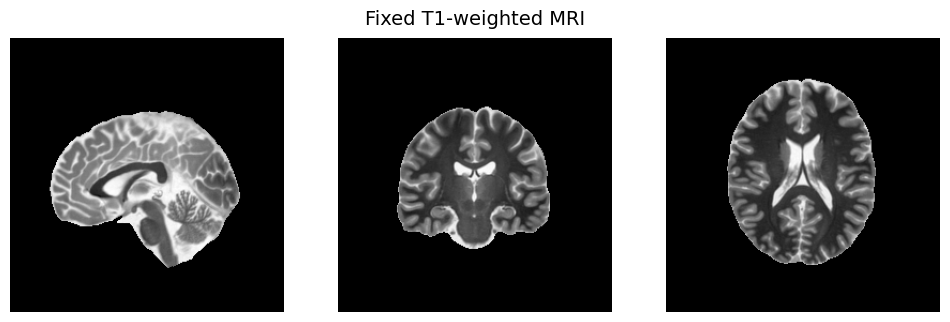

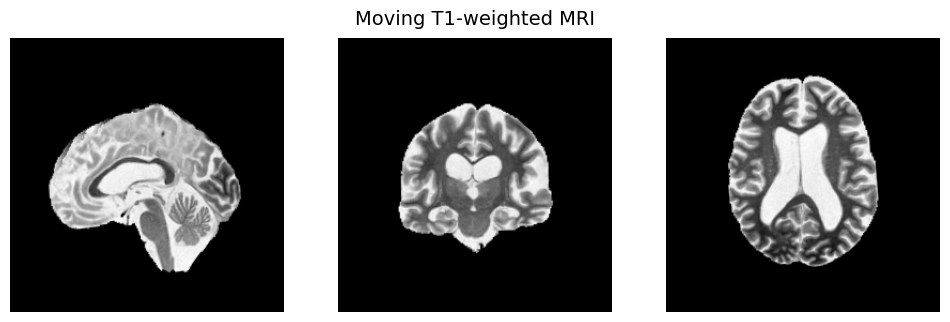

In [32]:
# Load both volumes
t1_fixed = sf.load_volume(affine_fixed).reshape(shape).reorient('ILP')
t1_moving = sf.load_volume(affine_moved).resample_like(t1_fixed)

show(t1_fixed, title='Fixed T1-weighted MRI')
show(t1_moving, title='Moving T1-weighted MRI')


1/1 ━━━━━━━━━━━━━━━━━━━━ 177s 177s/step
(256, 256, 256)
(1, 256, 256, 256, 1)


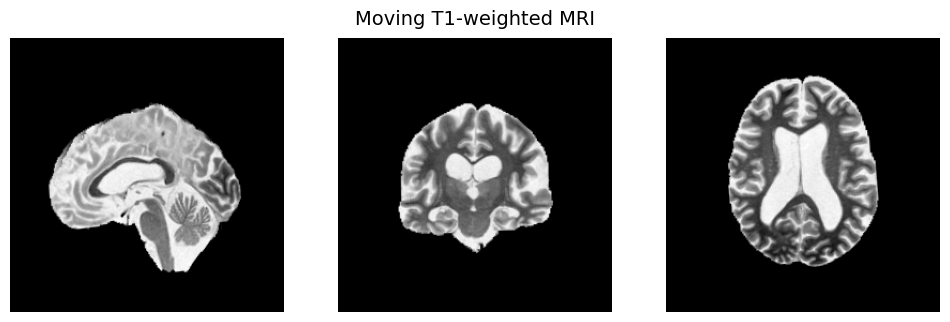

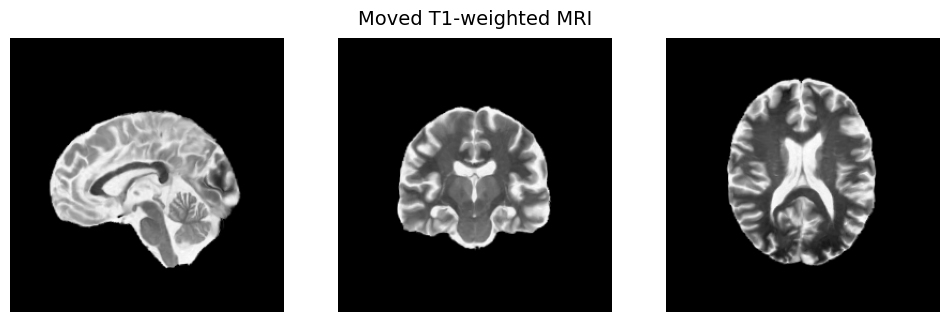

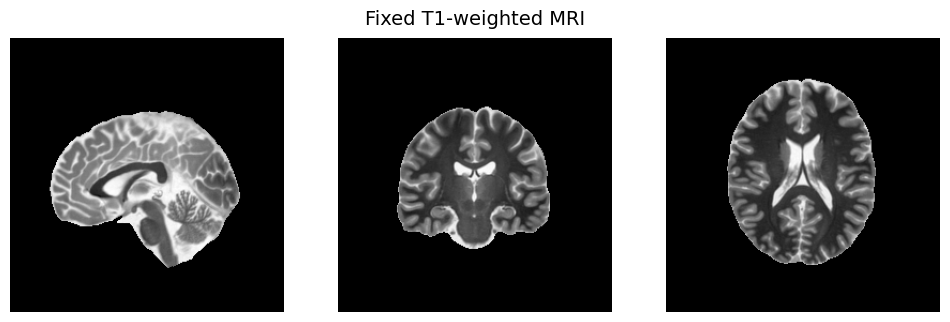

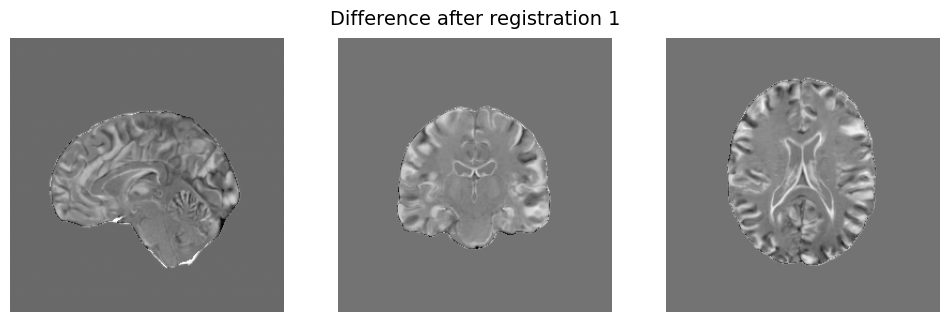

In [33]:
# STEP 2:
# Registration 1.
moving = normalize(t1_moving)
fixed = normalize(t1_fixed)

trans = model.predict((moving, fixed))

print(t1_moving.shape)
print(moving.shape)


moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))

show(t1_moving, title='Moving T1-weighted MRI')

show(moved, title='Moved T1-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 1')

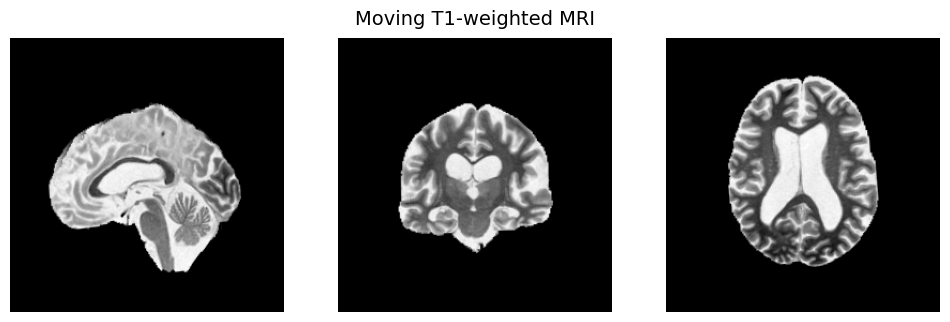

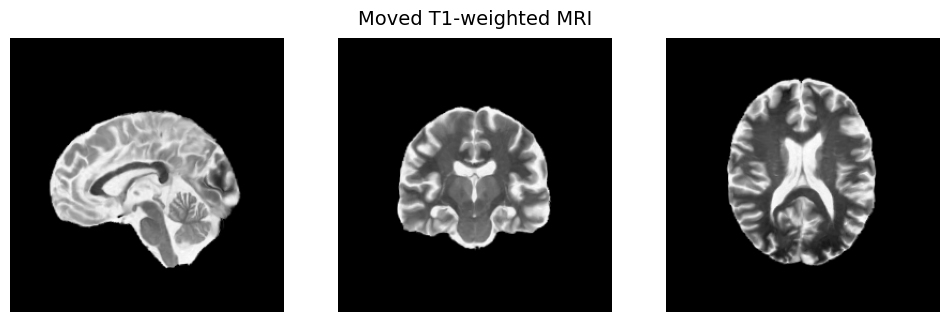

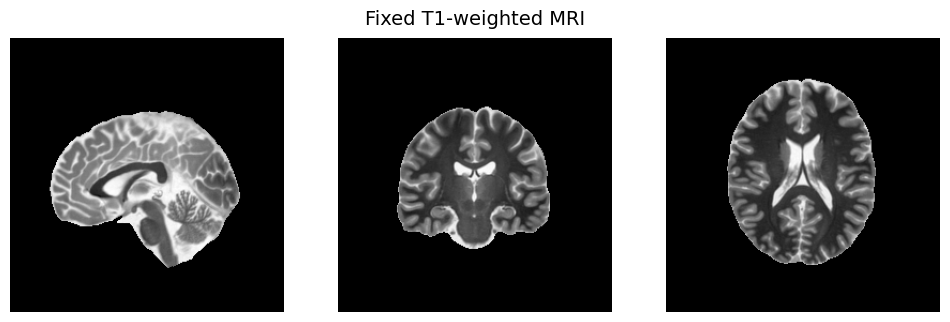

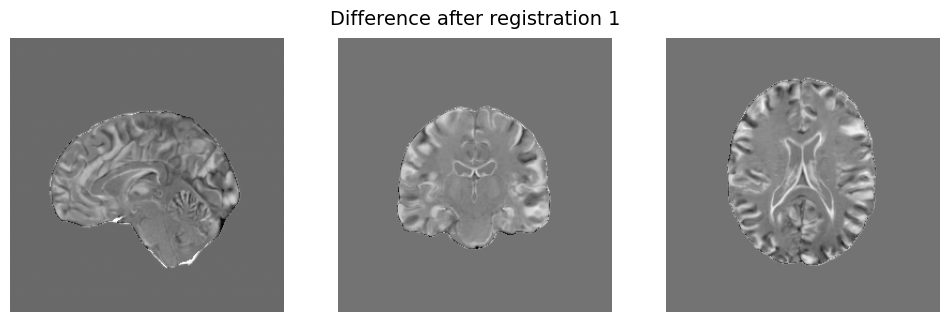

In [34]:
show(t1_moving, title='Moving T1-weighted MRI')

show(moved, title='Moved T1-weighted MRI')
show(fixed, title='Fixed T1-weighted MRI')
show(moved - fixed, title='Difference after registration 1')

In [35]:
# # # Registration 2.
# resid = model.predict((moved, fixed))
# trans = vxm.layers.ComposeTransform()((trans, resid))

# print(moving.shape)
# print(trans.shape)

# moved = vxm.layers.SpatialTransformer(fill_value=0)((moving, trans))
# show(moved, title='Moved T1-weighted MRI')
# show(fixed, title='Fixed T1-weighted MRI')
# show(moved - fixed, title='Difference after registration 2')

## Deformable Registration of Segmented Image

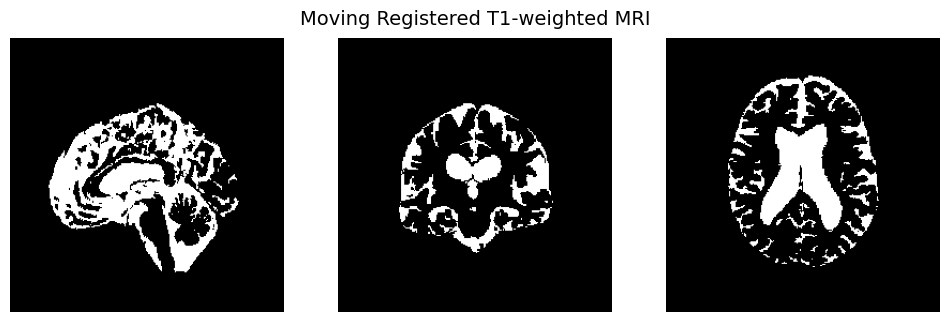

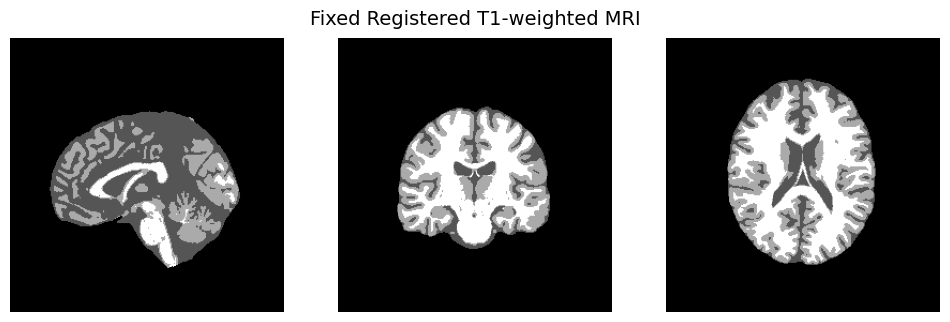

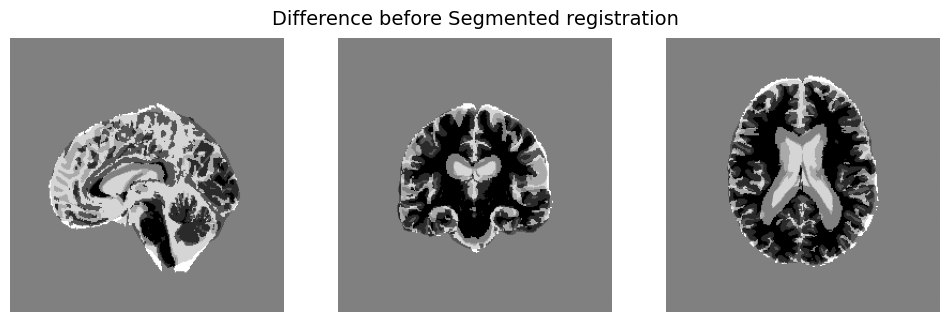

In [36]:
# Difference of Segmented images before registration.
# t1_fixed_seg = sf.load_volume('output/segmented/Img1/Img1_Seg.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
#######t1_fixed_seg = sf.load_volume('output/segmented/Img1/Img1_Seg.nii.gz').resize(voxsize=2).reshape(shape).reorient('ILP')
t1_fixed_seg = sf.load_volume('out_synth/template/colin27_t1_tal_lin_T1_LPS_dlicv_seg.nii.gz').reshape(shape).reorient('ILP')


# t1_moving_seg = sf.load_volume('segmented/Img2/Img2_Seg.nii.gz').resample_like(moving)
# t1_moving_seg = sf.load_volume('output/segmented/Img2/Img2_Seg.nii.gz').resample_like(t1_fixed)

# t1_moving_seg = sf.load_volume('out_synth/subj1/init/subj1_t1_mask.nii.gz').resample_like(t1_fixed)


## Working
# t1_moving_seg = sf.load_volume('out_synth/subj1/init/subj1_t1_mask.nii.gz')

t1_moving_seg = sf.load_volume('out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz').resample_like(t1_fixed_seg)
# t1_moving_seg = sf.load_volume('out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz').reshape(shape).reorient('ILP')


before = normalize(t1_moving_seg) - normalize(t1_fixed_seg)

show(t1_moving_seg, title='Moving Registered T1-weighted MRI')
show(t1_fixed_seg, title='Fixed Registered T1-weighted MRI')
show(before, title='Difference before Segmented registration')

## Apply Deformation Field to Segmented Image

(256, 256, 256)
(1, 256, 256, 256, 3)


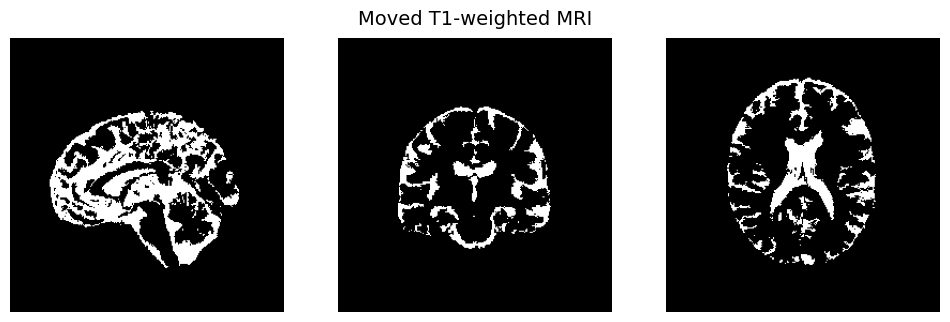

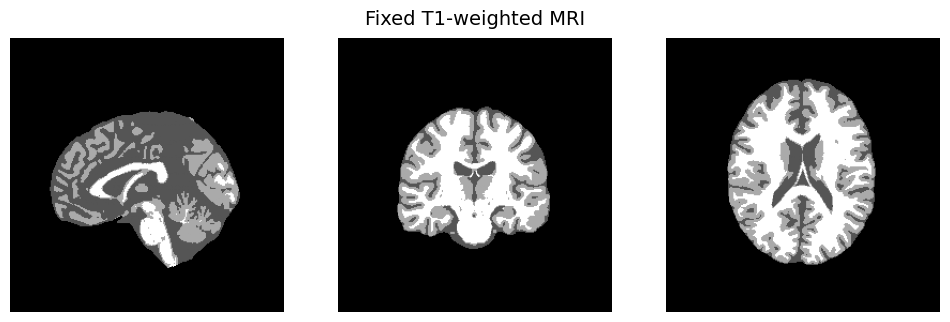

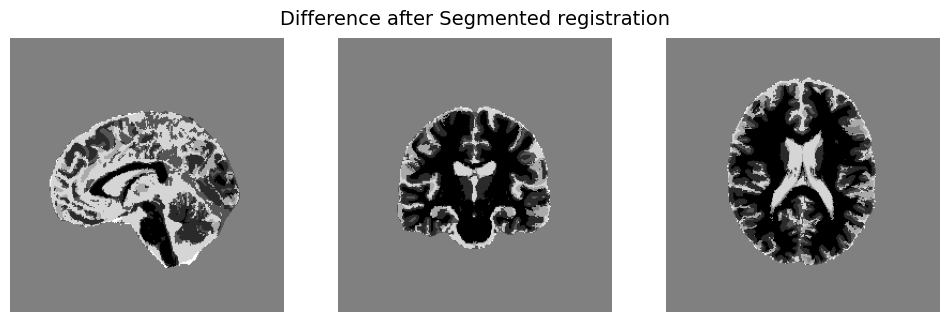

In [37]:
# Use transformation from previous registration
print(t1_moving_seg.shape)
print(trans.shape)

moving_seg = normalize(t1_moving_seg)
fixed_seg = normalize(t1_fixed_seg)

moved_seg = vxm.layers.SpatialTransformer(interp_method='nearest', fill_value=0)((moving_seg, trans))
show(moved_seg, title='Moved T1-weighted MRI')
show(fixed_seg, title='Fixed T1-weighted MRI')
show(moved_seg - fixed_seg, title='Difference after Segmented registration')

In [38]:
# # Save results.
t1_fixed.new(moved_seg[0]).save('out_synth/subj1/def_reg/subj1_t1_def.nii.gz')

###################
# sf.Warp(trans[0], source=t1_moving_seg, target=t1_fixed_seg, format=sf.Warp.Format.disp_crs).save('output/warp_seg.nii.gz')
# sf.Warp(trans[0], source=t1_moving_seg, target=t1_fixed, format=sf.Warp.Format.disp_crs).save('output/warp_seg2.nii.gz')

## Calculate Jacobian Matrix of the Deformation

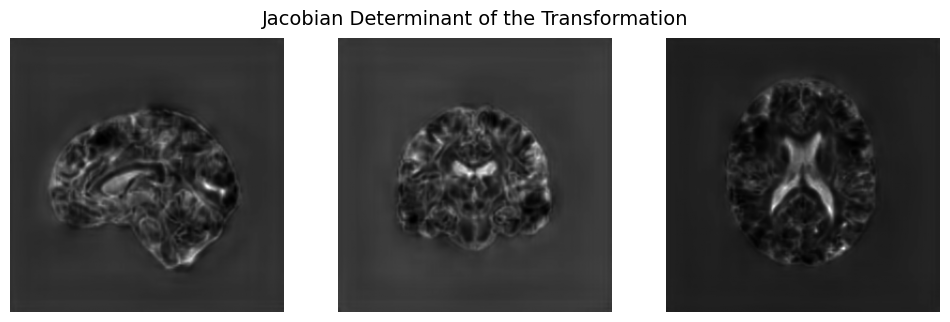

In [39]:
# Calculate the Jacobian
jacobian_det = vxm.py.utils.jacobian_determinant(trans[0])

# The output of jacobian_determinant
show(jacobian_det, title='Jacobian Determinant of the Transformation')

# Save the output
t1_fixed.new(jacobian_det).save('out_synth/subj1/def_reg/subj1_jac_det.nii.gz')

## Calculate Ravens Map

In [42]:
import pandas as pd
import json
import os
import argparse
import nibabel as nib
import numpy as np
from nilearn import image

def calc_ravens(f_jac, f_seg, labels, f_out):
    """
    Calculates a RAVENS map by masking a Jacobian determinant map with a list of labels from a segmentation file.
    It handles cases where the jacobian and segmentation images are in different spaces by resampling the segmentation.
    """
    # Read the reference jacobian image (this defines our target space)
    nii_jac = nib.load(f_jac)
    img_jac = nii_jac.get_fdata()

    print("nii_jac shape:", nii_jac.shape)
    print("img_jac shape:", img_jac.shape)

    
    # Read the segmentation image that needs to be resampled
    nii_seg = nib.load(f_seg)
    
    nii_seg_data = nii_seg.get_fdata()

    
    # --- RESAMPLE NIFTI OBJECTS USING NILEARN ---
    # Resample the segmentation image to match the jacobian's space (affine and shape).
    # We use 'nearest' interpolation, which is crucial for label maps to prevent creating new, non-existent label values.
    print(f"Resampling segmentation from {nii_seg.shape} to {nii_jac.shape}...")
    # nii_seg_resampled = image.resample_to_img(nii_seg, nii_jac, interpolation='nearest')

    nii_seg_resampled = nii_seg

    
    # Get the image data from the resampled NIfTI object
    img_seg_resampled = nii_seg_resampled.get_fdata()
    
    # # Make a combined mask for all desired labels from the *resampled* segmentation.
    # # np.isin() efficiently checks which elements of the segmentation array are present in the list of labels.
    # mask = np.isin(img_seg_resampled, labels).astype(np.uint8)
    
    # # Check if the mask contains any voxels for the given labels.
    # if np.sum(mask) == 0:
    #     print(f"Warning: None of the labels {labels} were found in the segmentation file after resampling. The output will be empty.")
    
    # Calculate ravens by applying the mask to the jacobian image.
    # This will set all voxels outside the mask to zero.
    # ravens = img_jac * mask
    ravens = img_jac * nii_seg_data

    
    # Save the resulting RAVENS map as a new NIfTI image.
    # It's important to use the affine transformation from the reference jacobian image.
    nii_out = nib.Nifti1Image(ravens, nii_jac.affine)
    nib.save(nii_out, f_out)
    print(f"RAVENS map saved to: {f_out}")



    ####### MULTIPLY WITH SCALE FACTOR
    ravens /= scale_factor


    # Save the resulting RAVENS map as a new NIfTI image.
    # It's important to use the affine transformation from the reference jacobian image.
    nii_out = nib.Nifti1Image(ravens, nii_jac.affine)
    file_out = "out_synth/subj1/def_reg/subj1_t1_RAVENS_scaled.nii.gz"
    nib.save(nii_out, file_out)
    print(f"RAVENS map saved to: {file_out}")

In [44]:
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "output/segmented/Img1/Img1_Seg.nii.gz", grouped_labels['gray_matter'], "output/ravens_gray_matter.nii.gz")
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "output/segmented/Img1/Img1_Seg.nii.gz", grouped_labels['deep_gray_matter'], "output/ravens_deep_gray_matter.nii.gz")
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "output/segmented/Img1/Img1_Seg.nii.gz", grouped_labels['white_matter'], "output/ravens_white_matter.nii.gz")
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "output/segmented/Img1/Img1_Seg.nii.gz", grouped_labels['ventricles'], "output/ravens_ventricles.nii.gz")
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "output/segmented/Img1/Img1_Seg.nii.gz", csf_label, "output/ravens_csf.nii.gz")

calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "out_synth/subj1/def_reg/subj1_t1_def.nii.gz", target_labels, "out_synth/subj1/def_reg/subj1_t1_RAVENS.nii.gz")
†
# calc_ravens("out_synth/subj1/def_reg/subj1_jac_det.nii.gz", "out_synth/subj1/init/subj1_t1.nii.gz", target_labels, "out_synth/subj1/def_reg/subj1_t1_RAVENS.nii.gz")



nii_jac shape: (256, 256, 256)
img_jac shape: (256, 256, 256)
Resampling segmentation from (256, 256, 256) to (256, 256, 256)...
RAVENS map saved to: out_synth/subj1/def_reg/subj1_t1_RAVENS.nii.gz
RAVENS map saved to: out_synth/subj1/def_reg/subj1_t1_RAVENS_scaled.nii.gz


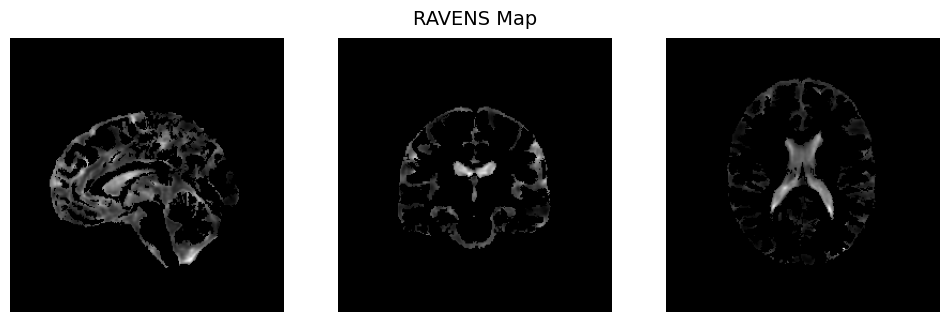

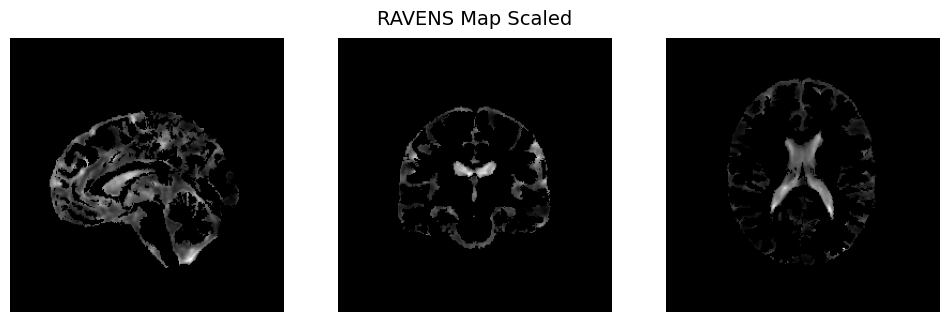

In [45]:
# t1_rav = sf.load_volume('output/ravens_gray_matter.nii.gz')
# show(t1_rav, title='RAVENS for Gray Matter')

# t1_rav = sf.load_volume('output/ravens_deep_gray_matter.nii.gz')
# show(t1_rav, title='RAVENS for Deep Gray Matter')

# t1_rav = sf.load_volume('output/ravens_white_matter.nii.gz')
# show(t1_rav, title='RAVENS for White Matter')
# #
# t1_rav = sf.load_volume('output/ravens_ventricles.nii.gz')
# show(t1_rav, title='RAVENS for Ventricles')


t1_rav = sf.load_volume('out_synth/subj1/def_reg/subj1_t1_RAVENS.nii.gz')
show(t1_rav, title='RAVENS Map')

t1_rav = sf.load_volume('out_synth/subj1/def_reg/subj1_t1_RAVENS_scaled.nii.gz')
show(t1_rav, title='RAVENS Map Scaled')

# t1_rav = sf.load_volume('ravens_misc.nii.gz')
# show(t1_rav, title='RAVENS for Miscellaneous')



In [55]:
import nibabel as nib
import numpy as np

# Load the nifti file
nii_file = nib.load('out_synth/subj1/def_reg/subj1_t1_RAVENS.nii.gz')

# Get the data from the file
data = nii_file.get_fdata()

# Calculate the sum of the values
total_sum = np.sum(data)

# Print the sum
print(f"The sum of the values in RAVENS is: {total_sum}")

The sum of the values in RAVENS is: 612584.2350684985


In [53]:
import nibabel as nib
import numpy as np

# Load the nifti file
nii_file = nib.load('out_synth/subj1/def_reg/subj1_t1_RAVENS_scaled.nii.gz')

# Get the data from the file
data = nii_file.get_fdata()

# Calculate the sum of the values
total_sum = np.sum(data)

# Print the sum
print(f"The sum of the values in RAVENS after scaling is: {total_sum}")

The sum of the values in RAVENS after scaling is: 838265.7707762115


In [54]:
import nibabel as nib
import numpy as np

# Load the nifti file
nii_file = nib.load(out_seg)


# nii_file = nib.load('output/segmented/Img1/Img1_Seg.nii.gz')
# nii_file = nib.load('out_synth/subj1/def_reg/subj1_t1_def.nii.gz')
# nii_file = nib.load('output/ravens_csf.nii.gz')
# nii_file = nib.load('out_synth/subj1/lin_reg/subj1_t1_seg_reg.nii.gz')


# Get the data from the file
data = nii_file.get_fdata()

# To count the values that are equal to 24,
# we use np.count_nonzero on a boolean mask of the data.
# voxel_count = np.count_nonzero(data == 24)
# target_labels = [1]
voxel_count = np.count_nonzero(np.isin(data, target_labels))

# voxel_count = np.count_nonzero(data)


# Print the count
print(f"The number of voxels with a value of X in the Original Image is: {voxel_count}")

The number of voxels with a value of X in the Original Image is: 362920


In [49]:
# Load the nifti file
nii_file = nib.load('out_synth/subj1/init/subj1_t1_mask.nii.gz')

# Get the data from the file
data = nii_file.get_fdata()

# Calculate the sum of the values
total_sum = np.sum(data)

# Print the sum
print(f"The sum of the values in Original MASK is: {total_sum}")

The sum of the values in Original MASK is: 362920.0


In [50]:
import nibabel as nib
import numpy as np

# Load the nifti file
nii_file = nib.load('out_synth/subj1/init/subj1_t1_mask.nii.gz')



# Get the data from the file
data = nii_file.get_fdata()

voxel_count = np.count_nonzero(data)


# Print the count
print(f"The count of the values in Original mask is: {voxel_count}")

The count of the values in Original mask is: 362920


In [51]:
# Log package versions.
!pip freeze

absl-py==2.3.0
aiobotocore @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b2htsn1rgl/croot/aiobotocore_1738237874912/work
aiohappyeyeballs @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b38qlemj37/croot/aiohappyeyeballs_1734469403568/work
aiohttp @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_44bhte2f2d/croot/aiohttp_1734692700992/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_39uesgct45/croot/alabaster_1718201495024/work
altair @ file:///private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_80u2hc4yvg/croot/altair_1738916172872/work
anaconda-catalogs @ file:///Users/builder/cbouss/perseverance-python-buildout/croot/anaconda-catalogs_1701813581302/work
annotated-types @ file:///private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/ab